# Deliverable 1
### Research Question
Based on performance metrics, are some football players overvalued?

Hypothesis:
- Players with higher goal-scoring rates have higher valuations, and those who are valuations far exceeding the indication given by the correlation are overvalued.

Performance metrics available:
- Goals scored per game
- Assists per game
- Minutes played
- Matches starting eleven
- Number of matches team captain
- Clean sheets (for goalkeepers) (!!We can leave goalkeepers out, since their value evaluation metrics do not correspond to those of other player positions)
- Age 
- Position (except goalkeeper since those have no goal and little to no assists)
- Foot
- Height

Required datasets:
- players.csv (to combine player-ids to actual names, birthcountry(?), age, position, foot, height, market value, highest market value)
- game_lineups.csv (to get whether the player was starting and if he was team captain (maybe redundant))
- appearances.csv (for each player appearance we get goals, assists, minutes_played)
- clubs.csv (to combine club-id to actual club names) (needed?)

# Deliverable 2

Import data

In [52]:
# Import packages
import pandas as pd, os, sys

# Load datasets
cwd = '.'
players = pd.read_csv(cwd+'/archive/players.csv')
lineups = pd.read_csv(cwd+'/archive/game_lineups.csv')
appearances = pd.read_csv(cwd+'/archive/appearances.csv')
clubs = pd.read_csv(cwd+'/archive/clubs.csv')

We can combine "lineups" with "appearances", since those are match-based, and we will add the number-of-appearances-column to the "players" dataset.

First we clean and preprocess the separate datasets by doing the following:

- Look for contradictions in the datasets "lineups" and "appearances"

- We join datasets on `game_id` and `player_id`

In [53]:
# First, we inspect the dataframe

print(appearances.isna().sum())
print(lineups.isna().sum())

print(lineups.shape, appearances.shape) #(2191911, 10) (1578761, 13)
game_stats_na = lineups.merge(appearances, how='inner', on=['player_id', 'game_id'])
print(game_stats_na.info())

game_stats_na['player_name_y'] = game_stats_na['player_name_y'].fillna(game_stats_na['player_name_x'])
game_stats = game_stats_na
print(game_stats.info())

# Since `date` and `player_name` should also be the same for both datasets we can look for contradictions now we have resolved all null values

contradicting_dates_count = (game_stats['date_x'] != game_stats['date_y']).sum()

print(f"Number of rows with non-matching dates: {contradicting_dates_count}")

contradicting_names_count = (game_stats['player_name_x'] != game_stats['player_name_y']).sum()

print(f"Number of rows with non-matching names: {contradicting_names_count}")


# The data contains no contradictions for the dates, however it does contain 31986 contradictions for the names

contradicting_names = game_stats[game_stats['player_name_x'] != game_stats['player_name_y']]
print(f"Unique contradicting names: {contradicting_names[['player_name_x', 'player_name_y']].nunique()}")

# We have 640 unique names that are contradicting

appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
dtype: int64
game_lineups_id    0
date               0
game_id            0
player_id          0
club_id            0
player_name        0
type               0
position           3
number             0
team_captain       0
dtype: int64
(2191911, 10) (1578761, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342767 entries, 0 to 1342766
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   game_lineups_id         1342767 non-null  object
 1   date_x                  1342767 non-null  object
 2   game_id                 1342767 non-nu

Solve contradictions by character standardization

In [54]:
# convert to string
players['first_name'] = players['first_name'].astype(str)
players['last_name'] = players['last_name'].astype(str)
players['name'] = players['name'].astype(str)

In [55]:
char_replacement = {
    '-': ' ',
    'ö': 'o',
    'ó': 'o',
    'ò': 'o',
    'í': 'i',
    'é': 'e',
    'ä': 'a',
    'ü': 'u',
    'ß': 'ss',
    'å': 'a',
    'ø': 'o',
    'ñ': 'n',
    'ç': 'c',
    'œ': 'oe',
    'æ': 'ae',
    'ė': 'e',
    'ż': 'z',
    'ł': 'l',
    'č': 'c',
    'ś': 's',
    'ź': 'z',
    'ñ': 'n',
    'ã': 'a',
    'į': 'i',
    'š': 's',
    'ž': 'z',
    'đ': 'd',
    'ć': 'c',
    'ț': 't',
    'ğ': 'g',
    'ş': 's',
    'î': 'i',
    'ă': 'a',
    'Ș': 'S',
    'Ț': 'T',
    'İ': 'I',
    'ı': 'i',
    'ё': 'e',
    'й': 'i',
    'ю': 'u',
    'я': 'ya',
    'ë': 'e',
    'ș': 's',
    'ţ': 't',
    'ï': 'i',

}

def replace_special_chars(text, replacements):
    for special_char, normal_char in replacements.items():
        text = text.lower().replace(special_char, normal_char)
    return text

game_stats['player_name_x'] = game_stats['player_name_x'].apply(replace_special_chars, args=(char_replacement,))
game_stats['player_name_y'] = game_stats['player_name_y'].apply(replace_special_chars, args=(char_replacement,))

# Replace special characters in the first and last name columns of the players dataframe
players['first_name'] = players['first_name'].apply(replace_special_chars, args=(char_replacement,))
players['last_name'] = players['last_name'].apply(replace_special_chars, args=(char_replacement,))
players['name'] = players['name'].apply(replace_special_chars, args=(char_replacement,))

contradicting_names_count = (game_stats['player_name_x'] != game_stats['player_name_y']).sum()
contradicting_names = game_stats[game_stats['player_name_x'] != game_stats['player_name_y']]
print(f"Number of rows with non-matching names: {contradicting_names_count}")
print(contradicting_names[['player_name_x', 'player_name_y']].nunique())

Number of rows with non-matching names: 8118
player_name_x    166
player_name_y    166
dtype: int64


After cleaning capitals and special characters we still have 166 contradictions left. After inspection we can conclude these contradictions are regarding the inclusion of middle names, no first name or no second name.

Since these do not directly affect our results we have chosen to make player_name_x the leading column since it is the most inclusive.

In [56]:
game_stats_cleaned = game_stats.drop(['player_name_y', 'date_y'], axis=1).rename(columns={'player_name_x':'player_name', 'date_x':'date'})

Looking for conflicts such as duplicate entries

In [57]:
duplicates = appearances.duplicated(subset=['player_id', 'game_id'], keep=False)
duplicate_entries = appearances[duplicates]

# We have 0 duplicate entries

appearance_counts = game_stats_cleaned.groupby('player_id')['player_id'].count().reset_index(name='number_of_appearances')

result_players = pd.merge(players, appearance_counts, on='player_id', how='left')

Since we are interested in the market value, we can remove all players for which we do not have an appearance count, because those players are not included in the metrics dataset.

In [58]:
result_players_clean = result_players.dropna(axis=0, how='any')

In [59]:
# Convert number of appearances to integer
result_players_clean['number_of_appearances'] = result_players_clean['number_of_appearances'].astype(int)

C:\Users\moura\AppData\Local\Temp\ipykernel_2096\3304332291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_players_clean['number_of_appearances'] = result_players_clean['number_of_appearances'].astype(int)


In [60]:
# Drop unnecessary columns
result_players_clean = result_players_clean.drop(['player_code', 'city_of_birth', 'country_of_citizenship', 'agent_name', 'image_url', 'url'], axis=1)
game_stats_cleaned = game_stats_cleaned.drop(['number'], axis=1)

# Change name of column name to player_name
result_players_clean = result_players_clean.rename(columns={'name':'player_name', 'current_club_id':'player_current_club_id'})

In [61]:
game_stats_cleaned = game_stats_cleaned.merge(result_players_clean, on='player_id', how='inner')

In [64]:
result_players_clean.columns

Index(['player_id', 'first_name', 'last_name', 'player_name', 'last_season',
       'player_current_club_id', 'country_of_birth', 'date_of_birth',
       'sub_position', 'position', 'foot', 'height_in_cm',
       'contract_expiration_date', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur', 'number_of_appearances'],
      dtype='object')

Saving the preprocessed data

In [ ]:
os.makedirs(cwd+'/clean', exist_ok=True)
game_stats_cleaned.to_csv(cwd+'/clean/game_stats_cleaned.csv', index=False)
result_players_clean.to_csv(cwd+'/clean/result_players_clean.csv', index=False)

In [ ]:
# Load datasets
import sys, pandas as pd
cwd = '.'
game_stats_cleaned = pd.read_csv(cwd+"/clean/game_stats_cleaned.csv") # index_col=0
result_players_clean = pd.read_csv(cwd+"/clean/result_players_clean.csv") # index_col=0

In [65]:
[col for col in game_stats_cleaned.columns if 'player' in col]

['player_id',
 'player_name_x',
 'player_club_id',
 'player_current_club_id_x',
 'player_name_y',
 'player_current_club_id_y']

# Deliverable 3
As part of the poster, we need to attempt to deliver the answer to the research question. Therefore a knowledge graph is created here.

In [66]:
from rdflib import Graph, URIRef, Literal, BNode, Namespace, RDF

n = Namespace(URIRef("http://example.org/"))
kg = Graph()
kg.bind("ex", n)

# Append player_id to knowledge graphs
for player_id in game_stats_cleaned.player_id.unique():
    # Create subset df
    player_df = game_stats_cleaned[game_stats_cleaned.player_id==player_id]
    # Append player_id to knowledge graph
    player_node = URIRef(n + str(player_id))
    kg.add((player_node, RDF.type, n.player))
    # Append player name to player_id
    player_name = player_df.player_name_x.iloc[0]
    kg.add((player_node, n.player_name, Literal(player_name)))
    # Append games to player_id
    for game_id in player_df.game_id:
        game_node = BNode()
        kg.add((game_node, RDF.type, n.game))
        kg.add((player_node, n.played_in_game, game_node))
        kg.add((game_node, n.id, Literal(game_id)))
        # Append attributes to game_id
        for attr, value in player_df[player_df.game_id==game_id].squeeze().items():
            kg.add((game_node, n[attr], Literal(value)))
    # Append attributes from result_players_clean to player_id
    for attr, value in result_players_clean[result_players_clean.player_id==player_id].squeeze().items():
        kg.add((player_node, n[attr], Literal(value if not isinstance(value,pd.Series) else None)))
# Save
kg.serialize(cwd+"/knowledge_graph.ttl", format="turtle")

<Graph identifier=N66911385dbff48b78e788e9df846bce9 (<class 'rdflib.graph.Graph'>)>

In [7]:
from rdflib import Graph
import oxrdflib, pyoxigraph	

# load serialized graph
g = Graph()
g.parse("./knowledge_graph.ttl", format="turtle")

<Graph identifier=N9ddf40e93e7a4e879585c692bd5b57cf (<class 'rdflib.graph.Graph'>)>

In [11]:
query = """
PREFIX ex: <http://example.org/>

SELECT ?player ?player_name ?goals ?assists ?minutes_played ?yellow_cards ?red_cards ?market_value
WHERE {
    ?player a ex:player ;
            ex:player_name ?player_name ;
            ex:market_value_in_eur ?market_value .

    OPTIONAL {
        ?player ex:played_in_game ?game .
        ?game ex:goals ?goals ;
              ex:assists ?assists ;
              ex:minutes_played ?minutes_played ;
              ex:yellow_cards ?yellow_cards ;
              ex:red_cards ?red_cards .
    }
}
"""

In [13]:
results = g.query(query)


In [17]:
data = []
for row in results:
    data.append({
        'player': str(row.player),
        'player_name': str(row.player_name),
        'goals': int(row.goals) if row.goals else 0,
        'assists': int(row.assists) if row.assists else 0,
        'minutes_played': int(row.minutes_played) if row.minutes_played else 0,
        'yellow_cards': int(row.yellow_cards) if row.yellow_cards else 0,
        'red_cards': int(row.red_cards) if row.red_cards else 0,
        'market_value': float(row.market_value)
    })

In [19]:
import pandas as pd
df = pd.DataFrame(data)

In [23]:
# Group by player and aggregate metrics
aggregated_df = df.groupby(['player', 'player_name', 'market_value']).agg({
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum'
}).reset_index()

In [24]:
# Define a performance score
aggregated_df['performance_score'] = (aggregated_df['goals'] * 4 + 
                                      aggregated_df['assists'] * 3 + 
                                      aggregated_df['minutes_played'] / 90 - 
                                      aggregated_df['yellow_cards'] * 2 - 
                                      aggregated_df['red_cards'] * 5)

In [27]:
aggregated_df.head()

,player,player_name,market_value,goals,assists,minutes_played,yellow_cards,red_cards,performance_score
0,http://example.org/100131,william carvalho,5000000.0,21,24,26407,87,2,265.411111
1,http://example.org/100303,rajko rotman,50000.0,2,4,6703,28,2,28.477778
2,http://example.org/1004301,jeremy jacquet,300000.0,0,0,15,0,0,0.166667
3,http://example.org/1004681,tony strata,50000.0,0,0,136,1,0,-0.488889
4,http://example.org/1004741,pedro,7000000.0,0,0,69,0,0,0.766667


<Axes: title={'center': 'Performance Score vs Market Value'}, xlabel='performance_score', ylabel='market_value'>

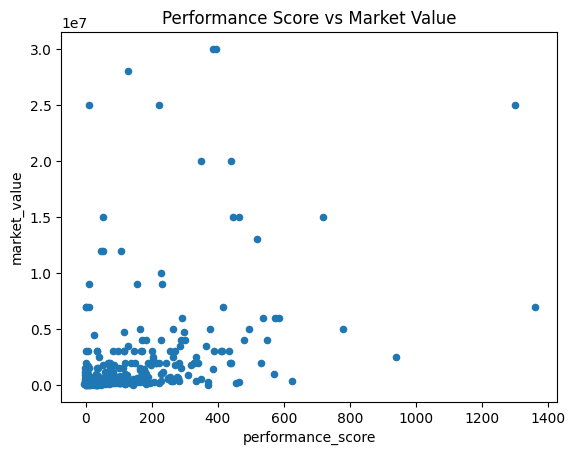

In [26]:
aggregated_df.plot(kind='scatter', x='performance_score', y='market_value', title='Performance Score vs Market Value')
